# Serving your model exercise

In [42]:
from random import random
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
import pickle
import requests
import json


import warnings
warnings.simplefilter(action='ignore')

## Intro
Reminder, there will usually be 3 different places where the code relevant to our model prediction runs:
1. **Training computer / server** - where we train our model and save it
2. **Inference server** - server that listens to REST API requests to make predictions / inferences with the model that was training on the model server. Potentially, we could have many such servers. 
3. **Client** - client application (browser, mobile app etc.) that needs a prediction, and requests from **inference server** over HTTP with REST API to make the prediction

## 1. Getting to a trained model
**- Choose one of the models you trained in one the previous exercises or any other model.** **Do not take something from many Flask examples online!**

**This code will run on the** **training server**


### Open the Heart disease dataset (attahced) and explore it lightly
##### Data Dictionary:

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type (4 values)
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results (values 0,1,2)
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 1 = normal; 2 = fixed defect; 3 = reversable defect
* target - 1 or 0 (Has / Doesn;t have heart disease)


**- Specify where can one download the dataset from (to be used during checking the exercise)**


https://www.kaggle.com/johnsmith88/heart-disease-dataset

**- Say in one word what is the business problem and what you are predicting**



The business  problem: to predict wheather a person has a heart disease or not.

**- Preprocess, split to train and test dataset**


In [2]:
heart = pd.read_csv('heart.csv')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
heart.shape

(1025, 14)

Let's deal with duplicates and missing values

In [4]:
heart.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

no Nan - good

Drop duplicates

In [5]:
heart.drop_duplicates(inplace=True)

Shape check

In [6]:
heart.shape

(302, 14)

In [7]:
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Determine categorical and numerical features

In [8]:
num_features = ['age','trestbps','chol','restecg','thalach','oldpeak']
cat_features = ['sex','cp','fbs','exang','ca','thal','slope','restecg']

heart = heart[['sex','cp','fbs','exang','slope','restecg','ca',
               'thal','age','trestbps','chol','thalach','oldpeak','target']]

Let's plot our features

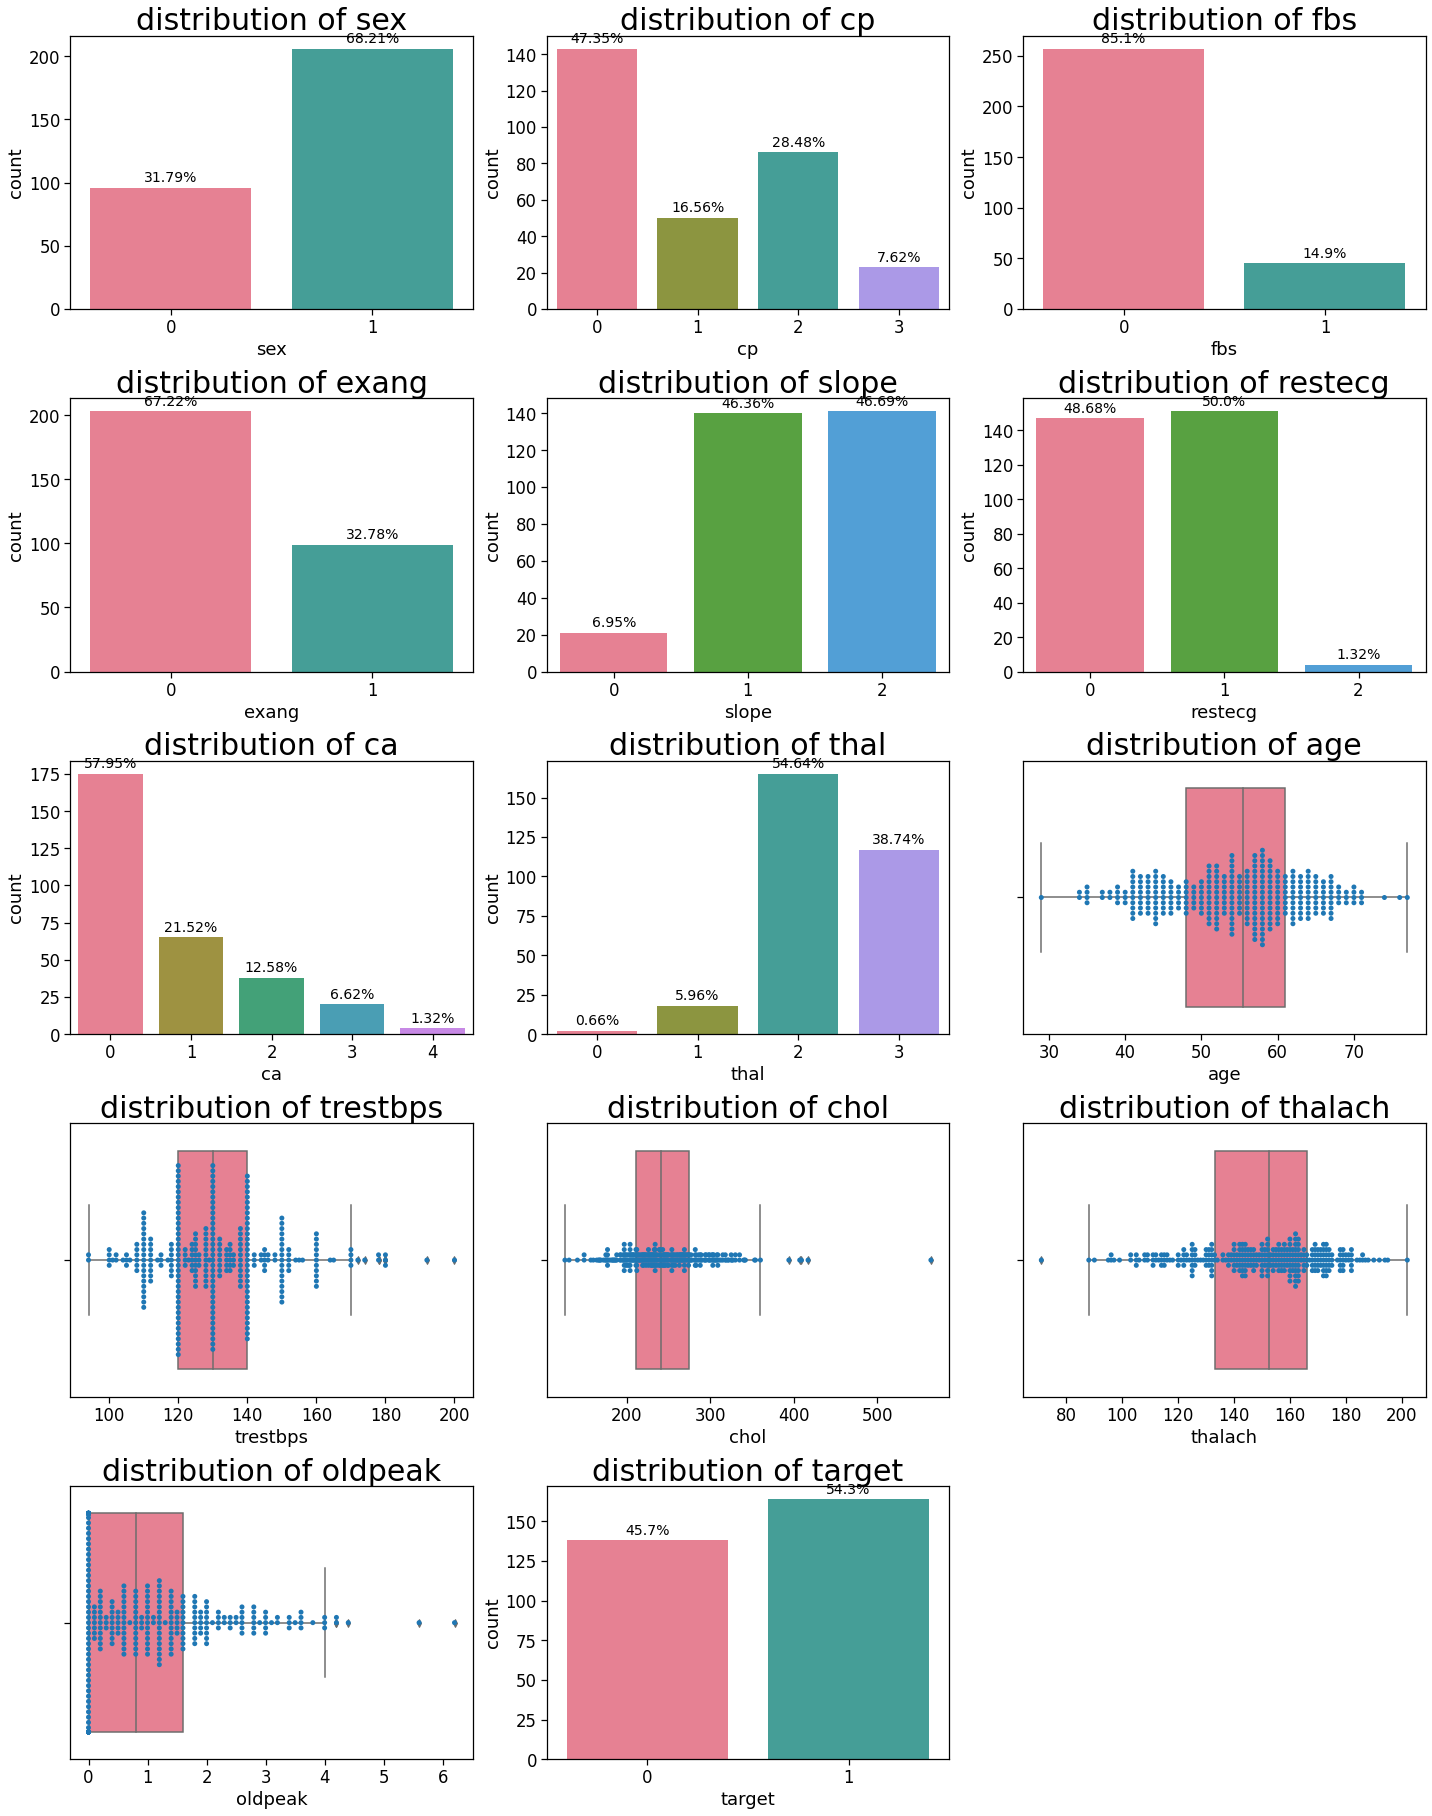

In [9]:
plt.figure(figsize=(20,75))
for i,col in enumerate(heart):
    plt.subplot(15,3,i+1)
    plt.tight_layout()
    plt.title(f'distribution of {col}', fontsize=30)
    if col not in('chol', 'age','trestbps','thalach','oldpeak'):
        bar = sns.countplot(x=col, palette="husl", data=heart)
        for p in bar.patches:
            bar.annotate('{}%'.format(round(p.get_height()/len(heart)*100,2), '.2f'), \
                       (p.get_x() + p.get_width() / 2.,p.get_height()),ha = 'center', \
                       va = 'center',xytext = (0, 10),textcoords = 'offset points',size = 14)
    else:
        a = sns.swarmplot(heart[col])  
        b = sns.boxplot(heart[col], palette='husl')

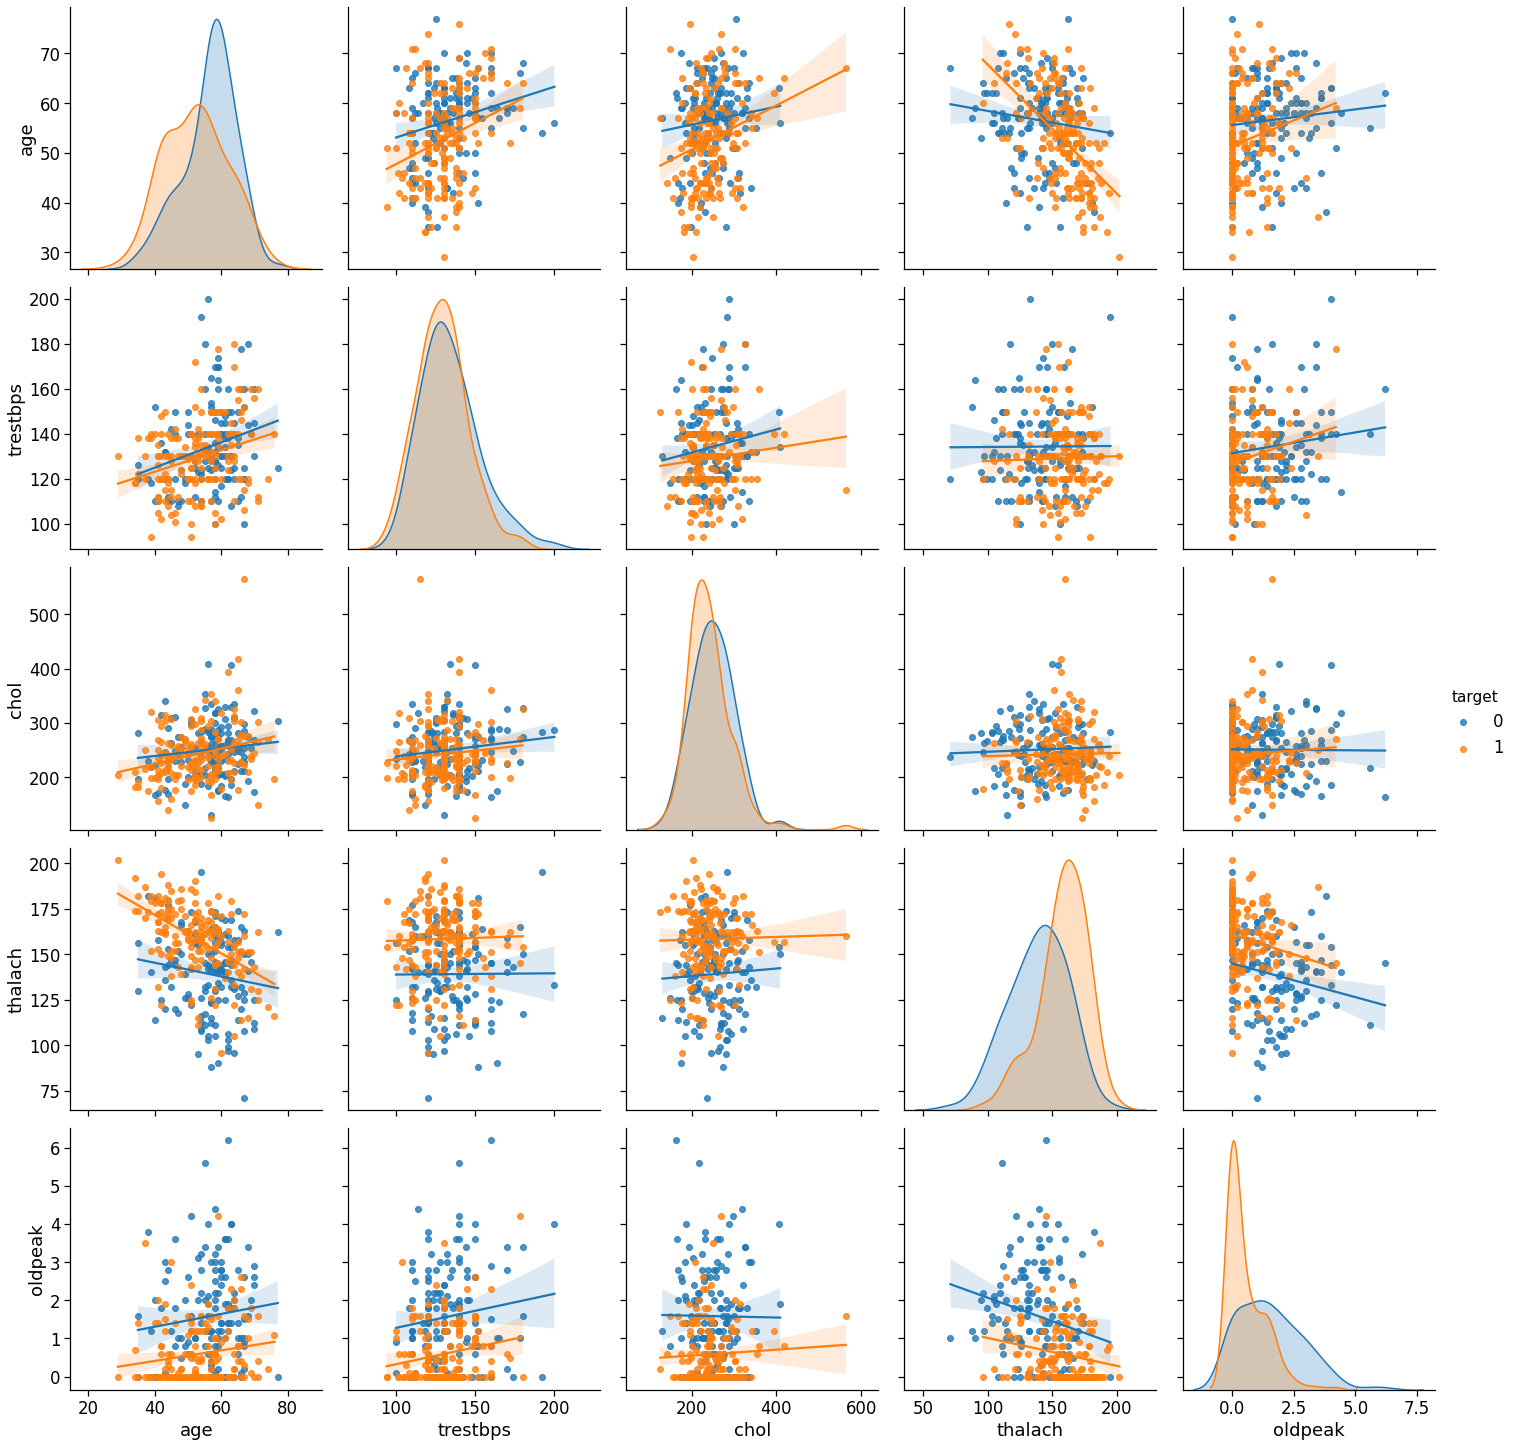

In [10]:
MF_pairplot = sns.pairplot(heart[['age','trestbps','chol','thalach','oldpeak','target']],
                           hue='target', kind ='reg', height = 4)
MF_pairplot;

There is a lot of overlap between the classes for many of the numerical features, suggesting that the use of non-linear classification algorithms such as k-Nearest Neighbours, Decision Trees or Random Forests would be more suitable for performing classification

I guess we have not much data here, so we have to stratify by our target to be sure in fare prediction

In [68]:
features = [x for x in heart.columns if x != 'target']
target = 'target'

rel_data = heart[features + [target]]
X = rel_data[features]
y = rel_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = .2)

print(f'Splited  dataset into a 2 sets: \
\nTrain set is:{round(len(X_train)/len(rel_data),1)*100}% \
\nTest set is:{round(len(X_test)/len(rel_data), 1)*100}%')

Splited  dataset into a 2 sets: 
Train set is:80.0% 
Test set is:20.0%


In [69]:
X_test

,sex,cp,fbs,exang,slope,restecg,ca,thal,age,trestbps,chol,thalach,oldpeak
27,0,1,1,0,2,0,2,2,58,136,319,152,0.0
498,1,0,0,0,2,1,0,2,54,140,239,160,1.2
168,1,2,0,0,2,1,1,2,43,130,315,162,1.9
719,1,0,1,0,2,1,3,3,52,108,233,147,0.1
20,1,2,0,0,1,0,0,2,60,140,185,155,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,1,1,0,0,2,0,0,3,56,130,221,163,0.0
113,1,0,0,1,1,1,1,3,57,110,335,143,3.0
582,1,1,0,0,2,1,0,2,55,130,262,155,0.0
152,1,0,0,0,2,0,2,3,58,125,300,171,0.0


In [70]:
pd.Series(y_train).value_counts()/len(y_train)


1    0.543568
0    0.456432
Name: target, dtype: float64

In [71]:
pd.Series(y_test).value_counts()/len(y_test)


1    0.540984
0    0.459016
Name: target, dtype: float64

In [72]:
heart.target.value_counts()/len(heart)


1    0.543046
0    0.456954
Name: target, dtype: float64

The spliting went well enough

Use GridSearchCV to find the best n_neighbors for our model

In [73]:
model = KNeighborsClassifier()
params_KNN = dict(n_neighbors = range(1,10))
grid_search_KNN = GridSearchCV(model, param_grid = params_KNN, cv =3, scoring='recall')
grid_search_KNN.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, scoring='recall')

Best n_neighbors for our model is:

In [74]:
grid_search_KNN.best_params_

{'n_neighbors': 7}

**- Train the model - the exact accuracy is not of big importance here**


In [75]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

Let's look on our score statistics

In [76]:
def get_stats(model, x_test_input=X_test, y_test_input=y_test,
             x_train_inp=X_train, y_train_inp=y_train):
    y_pred = np.round(model.predict(x_test_input))
    y_pred_train = np.round(model.predict(x_train_inp))
    accuracy_test = metrics.accuracy_score(y_test_input, y_pred)
    accuracy_train = metrics.accuracy_score(y_train_inp, y_pred_train)
    print("Accuracy Test: {0}".format(round(accuracy_test, 3)))
    print("Accuracy Train: {0}".format(round(accuracy_train, 3)))
    print(classification_report(y_test_input, y_pred))

In [77]:
get_stats(knn, x_test_input=X_test, y_test_input=y_test,
             x_train_inp=X_train, y_train_inp=y_train)

Accuracy Test: 0.639
Accuracy Train: 0.726
              precision    recall  f1-score   support

           0       0.60      0.64      0.62        28
           1       0.68      0.64      0.66        33

    accuracy                           0.64        61
   macro avg       0.64      0.64      0.64        61
weighted avg       0.64      0.64      0.64        61



We got not very impressive results, but our model is not bad: we will be mistaking in 15% with prediction of  heart disease  according to accuracy metric. And only 85% from our correct predicted as with a heart disease will be correct. (We have to decrease False Negative rate to increase recall)

**- Do a few predictions of the model locally**

In [78]:
y_pred = knn.predict(X_test)

In [79]:
def predict_for_one(indx,X_test, model):
    return int(model.predict(X_test[indx:indx+1]))

In [80]:
predict_for_one(10,X_test,knn)

1

In [81]:
predict_for_one(50,X_test,knn)

1

## 2. Save you model, predict with saved model

**Simulate in this notebook code that will happen during training on the raining server:**
**- Using `pickle`, save your model to disk. Reference: https://scikit-learn.org/stable/modules/model_persistence.html**


Here the regular code from Jupiter notebook

In [82]:
# save the model to disk
filename = 'my_knn_model.pkl'
pickle.dump(knn, open(filename, 'wb'))

**- Save the test dataset to file.**

In [83]:
test_filename = 'my_Test_set.csv'

X_test.to_csv(test_filename, index=False)

 **- What's a good format(s) for saving datasets?**


The good format is csv

<b>Simulate in this notebook code that will happen during inference on the **inference server**:
- Load the model again with `pickle` in a Python file in PyCharm.<b>


In [84]:
with open(filename, 'rb') as f:
    model = pickle.load(f)
model

KNeighborsClassifier(n_neighbors=7)

**- Read the test dataset file,**


In [85]:
X_test_from_file = pd.read_csv(test_filename)
X_test_from_file

,sex,cp,fbs,exang,slope,restecg,ca,thal,age,trestbps,chol,thalach,oldpeak
0,0,1,1,0,2,0,2,2,58,136,319,152,0.0
1,1,0,0,0,2,1,0,2,54,140,239,160,1.2
2,1,2,0,0,2,1,1,2,43,130,315,162,1.9
3,1,0,1,0,2,1,3,3,52,108,233,147,0.1
4,1,2,0,0,1,0,0,2,60,140,185,155,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1,1,0,0,2,0,0,3,56,130,221,163,0.0
57,1,0,0,1,1,1,1,3,57,110,335,143,3.0
58,1,1,0,0,2,1,0,2,55,130,262,155,0.0
59,1,0,0,0,2,0,2,3,58,125,300,171,0.0


 **and perform some predictions**

In [86]:
predict_for_one(10,X_test_from_file,model)

1

In [87]:
predict_for_one(50,X_test_from_file,model)

1

**- Compare the predictions received before saving the model, and after reading a saved model.  Show that you get the same results.**

In [88]:
instance_range = np.random.randint(0, len(X_test), 10)
print('indexes to predict:', instance_range)
print('\nPrediction from set before saving the model')
for indx in instance_range:
    print(predict_for_one(indx, X_test, knn), end=' ')
    
    
print('\n\nPrediction from set after saving the model')
for indx in instance_range:
    print(predict_for_one(indx, X_test_from_file, model), end=' ')
        
        

indexes to predict: [59  1 13 37 18 18 51 53 59 57]

Prediction from set before saving the model
1 1 0 0 1 1 1 0 1 0 

Prediction from set after saving the model
1 1 0 0 1 1 1 0 1 0 

We  got the same results

Here code from PyCharm in one cell (local predictions)

## 3. Serve your model


Now we are done with **training server**, since we have the saved model.  From now all that's relevant is **inference server** and **client** code.

Let's create the **inference server** that answers to REST APIs with predictions:


- Using `flask`, create a Pycharm project and implement the following prediction API:
- **Single prediction API** that receives inputs as parameters, and returns a single prediction.  
- Example: http://localhost:5000/predict_single?key1=value1&key2=value2 (replace `key1` etc. names with your relevant feature names)
- In order to create a `requirements.txt` file later (question 6) with all the prerequisites for running your **inference server** code:
  - When creating your PyCharm project, create a Python virtual environment for the server code
  - When creating the virtual environment, do it on top of bare Python installation (freshly downloaded, not one you installed many additional packages on) - otherwise it will be hard to see what you actually need for the specific project.
  - Use the virtual environment only for **inference server** code (otherwise it will include unnecessary modules).
  
  **Remember**:
  - Having too few modules will mean inference server that will not work
  - Having too many modules means paying for unnecessary storage and maintanence in potentially large number of inference servers
- Consider what's the best place to put the code that reads from the model.  Why?
- In general, take runtime efficiency into account.  Your API might be called large number of times per second, and you will be paying for more inference servers if your code is not efficient.
- Copy your **inference server** code also here for reference

Here the code from PyCharm (server predictions using file with local predictions)

## 4. Consume you model with python

Use Python `requests` module from here to make a prediction.  Print input and output of the prediction.

**Warning**: don't get used to seeing it in a Jupyter notebook.  This code will usually run inside a **client application**

We have predicted for this instance twice, now let's use it again

In [55]:
X_test[10:11]

,sex,cp,fbs,exang,slope,restecg,ca,thal,age,trestbps,chol,thalach,oldpeak
10,0,3,0,0,2,1,2,2,69,140,239,151,1.8


In [56]:
d = X_test.to_dict('records')[10]
d

{'sex': 0,
 'cp': 3,
 'fbs': 0,
 'exang': 0,
 'slope': 2,
 'restecg': 1,
 'ca': 2,
 'thal': 2,
 'age': 69,
 'trestbps': 140,
 'chol': 239,
 'thalach': 151,
 'oldpeak': 1.8}

In [57]:
requests.get('http://127.0.0.1:5000/pred_one', params=d).text

'1'

## 5. Using JSON files

- Using `flask`, add code to your previous file in Pycharm to create the following prediction API:
- **Multiple prediction API** that receives input many observations to predict on as a json file, and returns a json file with predictions.
- Your **JSON** file format has to be efficient, clear and following JSON file syntax: 
  - JSON file is a nested structure of potentially multiple dictionaries and lists 
  - JSON file tip: Use lists, every member in the list can be a dictionary of all the features.  
  - JSON file tip: Do not put indexes of predictions into the JSON files, indexes of predictions can be easily computed with Python code later 
  - JSON files are sometimes slightly verbose, but are extremely human readable.  Just looking at your JSON files of input and output, is it possible to understand what were the observations in input and what were the predictions in output?
- Think about efficiency of your code - your REST API might be called a huge number of times, with a huge number of observations every time.  Can part of the code be done only once?  Can you predict on everything together? Can you do less or cheaper data conversions?
- Example: http://localhost:5000/predict
- Reference https://pythonise.com/series/learning-flask/working-with-json-in-flask
- Do you need a GET or a POST type of REST API call? Does it change what you did in step 3?  Conceptually, would you say it makes sense to use GET or POST types for predictions?
- Copy your **inference server** code also here for reference 

Let's take few rows for prediction

In [58]:
X_test.iloc[10:20]

,sex,cp,fbs,exang,slope,restecg,ca,thal,age,trestbps,chol,thalach,oldpeak
10,0,3,0,0,2,1,2,2,69,140,239,151,1.8
11,1,0,0,1,1,0,2,2,67,100,299,125,0.9
12,1,2,0,0,2,1,0,2,50,129,196,163,0.0
13,1,2,0,0,1,0,1,3,58,112,230,165,2.5
14,1,0,0,1,1,1,0,3,35,120,198,130,1.6
15,1,1,0,1,2,1,0,2,59,140,221,164,0.0
16,1,0,0,0,2,0,1,2,44,112,290,153,0.0
17,1,2,0,0,1,1,0,2,46,150,231,147,3.6
18,1,2,0,1,1,1,1,3,70,160,269,112,2.9
19,0,2,0,0,2,1,1,2,67,152,277,172,0.0


Transform into json

In [59]:
d = X_test.iloc[10:20].to_json(orient='records')
d

'[{"sex":0,"cp":3,"fbs":0,"exang":0,"slope":2,"restecg":1,"ca":2,"thal":2,"age":69,"trestbps":140,"chol":239,"thalach":151,"oldpeak":1.8},{"sex":1,"cp":0,"fbs":0,"exang":1,"slope":1,"restecg":0,"ca":2,"thal":2,"age":67,"trestbps":100,"chol":299,"thalach":125,"oldpeak":0.9},{"sex":1,"cp":2,"fbs":0,"exang":0,"slope":2,"restecg":1,"ca":0,"thal":2,"age":50,"trestbps":129,"chol":196,"thalach":163,"oldpeak":0.0},{"sex":1,"cp":2,"fbs":0,"exang":0,"slope":1,"restecg":0,"ca":1,"thal":3,"age":58,"trestbps":112,"chol":230,"thalach":165,"oldpeak":2.5},{"sex":1,"cp":0,"fbs":0,"exang":1,"slope":1,"restecg":1,"ca":0,"thal":3,"age":35,"trestbps":120,"chol":198,"thalach":130,"oldpeak":1.6},{"sex":1,"cp":1,"fbs":0,"exang":1,"slope":2,"restecg":1,"ca":0,"thal":2,"age":59,"trestbps":140,"chol":221,"thalach":164,"oldpeak":0.0},{"sex":1,"cp":0,"fbs":0,"exang":0,"slope":2,"restecg":0,"ca":1,"thal":2,"age":44,"trestbps":112,"chol":290,"thalach":153,"oldpeak":0.0},{"sex":1,"cp":2,"fbs":0,"exang":0,"slope":1,"r

Use Python `requests` module from here to make a prediction, and output part of the input, and part of the result.  

**Warning**: don't get used to seeing it in a Jupyter notebook.  This code will usually run inside a **client application**

Check if we can transform our json back into dataFrame

In [60]:
import json
from_json = pd.DataFrame.from_dict(json.loads(d))
from_json

,sex,cp,fbs,exang,slope,restecg,ca,thal,age,trestbps,chol,thalach,oldpeak
0,0,3,0,0,2,1,2,2,69,140,239,151,1.8
1,1,0,0,1,1,0,2,2,67,100,299,125,0.9
2,1,2,0,0,2,1,0,2,50,129,196,163,0.0
3,1,2,0,0,1,0,1,3,58,112,230,165,2.5
4,1,0,0,1,1,1,0,3,35,120,198,130,1.6
5,1,1,0,1,2,1,0,2,59,140,221,164,0.0
6,1,0,0,0,2,0,1,2,44,112,290,153,0.0
7,1,2,0,0,1,1,0,2,46,150,231,147,3.6
8,1,2,0,1,1,1,1,3,70,160,269,112,2.9
9,0,2,0,0,2,1,1,2,67,152,277,172,0.0


Function to make prediction for some instances from the X_test set

Request for set prediction by json

In [62]:
url="http://127.0.0.1:5000/pred"
headers = {'Content-type': 'application/json'}
r = requests.post(url, data=d)
r.text

'[1 0 1 0 1 1 0 1 0 1]'

## 6. Create `requirements.txt` file
- Create a `requirements.txt` file.  You can do it manually or by using `pip freeze`: https://pip.pypa.io/en/stable/reference/pip_freeze/ 
- Did you include the version numbers in the `requirements.txt`?  Explain pluses and minuses of including them, and why you chose what you chose
- Add this file to your PyCharm project
- Simulate a new **inference server**: Test `requirements.txt` to make sure it has all the needed requirements:
  - Create new virtual environment on top of a a bare Python installation.
  - Use your code file + `requirements.txt` file by doing `pip install -r requirements.txt`
  - Make sure your Flask server works and predicts correctly

**Note**:  It's easier to see we included all modules needed by doing the steps above. It's much harder to see modules that are in the list and we don't need.  This is why it's important to follow the steps in question 3 on creating a virtual environment on top of a bare Python installation, and not installing anything not important for inference server on top of it.

Copy your `requirements.txt` here for reference:

## 7. Submit a zip file with:
1. This notebook
2. requirements.txt
3. Your Python server file

## 8. Bonus: Create a friendly interface (HTML Form) for your single Prediction API
Instead of returning it as a text or as JSON, write some HTML form that summarizes the inputs and the predictions.

Copy your server code also here for reference 

In [40]:
# your code here

Use Python `requests`, or if you find a nicer way to output the HTML response here: 

In [41]:
# your code here

## 9. Bonus: Add a nginx and Gunicorn (Linux) and Waitress (Windows) to your Flask deployment.
1. Make sure your prediction API still works.
2. Copy setups scripts here